# CNN-lytical Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [4]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
# #     When running on the CuDNN backend, two further options must be set
#     # torch.backends.cudnn.deterministic = True
#     # torch.backends.cudnn.benchmark = False
#     # # Set a fixed value for the hash seed
#     # os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1_IHICOfAsT7x63VBBuN1WMh4bDqtUThp/view?usp=sharing) shared for this assignment here.

In [6]:
# load the data set
with open ("train_cifar.pkl",'rb') as mydata:
    dataset=pickle.load(mydata)
# print(dataset)

X = dataset['X']
y = dataset['y']


StandDev=np.std(X,axis=0,keepdims=True)
Mean=np.mean(X,axis=0,keepdims=True)
Normalised_X=(X-Mean)/(StandDev+1e-7)

print(X.shape)

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
testsize=0.5
X_train, X_test, y_train, y_test = train_test_split(Normalised_X, y, test_size=testsize)
print(X_train.shape)
print(y_train.shape)

# print(X[1],y[1])

(50000, 32, 32, 3)
(25000, 32, 32, 3)
(25000, 1)


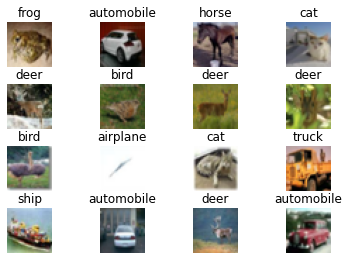

In [7]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
classes=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(16):
    plt.subplot(4,4,i+1)
    index=random.randrange(0,50000)
    image = X[index]
#     image = np.array(image, dtype='float')
#     pixels = image.reshape(3,32,32).transpose(1,2,0)
#     print(pixels.shape)
    plt.imshow(image)
    plt.title(classes[y[index][0]])
    plt.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

# img=X[0]
# img.shape
# plt.imshow(img)

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [8]:
# define your dataset class

class CIFAR(Dataset):
    
    def __init__(self,X,y):
        self.X=torch.Tensor(X)
        self.y=torch.Tensor(y)
        self.n_samples=X.shape[0]
        
    def __getitem__(self,index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    

dataset=CIFAR(X_train,y_train)
dataloader=DataLoader(dataset=dataset, batch_size=256,shuffle=True)



## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [9]:
# define a child class of nn.Module for your model
# specify the architecture here itself
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(3,4,5,padding=2)
        self.conv2=nn.Conv2d(4,8,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv3=nn.Conv2d(8,16,5,padding=2)
        self.conv4=nn.Conv2d(16,20,5,padding=2)
        self.conv5=nn.Conv2d(20,32,5)
        self.bn2d1=nn.BatchNorm2d(4)
        self.bn2d2=nn.BatchNorm2d(8)
        self.bn2d3=nn.BatchNorm2d(16)
        self.bn2d4=nn.BatchNorm2d(20)
        self.bn2d5=nn.BatchNorm2d(32)
        self.fc1=nn.Linear(32*5*5,64)
        self.fc2=nn.Linear(64,32)
        self.fc3=nn.Linear(32,10)
        self.bn1d1=nn.BatchNorm1d(64)
        self.bn1d2=nn.BatchNorm1d(32)
        self.relu=nn.ReLU()
#         self.conv1=nn.Conv2d(3,8,5)
#         self.pool=nn.MaxPool2d(2,2)
#         self.conv2=nn.Conv2d(8,16,5)
#         self.relu=nn.ReLU()
#         self.fc1=nn.Linear(16*5*5,120)
#         self.fc2=nn.Linear(120,84)
#         self.fc3=nn.Linear(84,10)
#         self.bn2d1=nn.BatchNorm2d(8)
#         self.bn2d2=nn.BatchNorm2d(16)
#         self.bn1d1=nn.BatchNorm1d(120)
#         self.bn1d2=nn.BatchNorm1d(84)

    

    def forward(self,x):
        out=self.relu(self.bn2d1(self.conv1(x)))
        out=self.relu(self.bn2d2(self.conv2(out)))
        out=self.pool(out)
        out=self.relu(self.bn2d3(self.conv3(out)))
        out=self.relu(self.bn2d4(self.conv4(out)))
        out=self.pool(self.relu(self.bn2d5(self.conv5(out))))
        out=torch.reshape(out,(-1,32*5*5))
        out=self.relu(self.bn1d1(self.fc1(out)))
        out=self.relu(self.bn1d2(self.fc2(out)))
        out=self.fc3(out)

#         x=self.pool(self.relu(self.bn2d1(self.conv1(x))))
#         x=self.pool(self.relu(self.bn2d2(self.conv2(x))))
#         x=torch.reshape(x,(-1,16*5*5))
#         x=self.relu(self.bn1d1(self.fc1(x)))
#         x=self.relu(self.bn1d2(self.fc2(x)))
#         x=self.fc3(x)


        return out

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [10]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    n_total_steps=len(train_loader)
    num_epochs=20
    for epoch in range(num_epochs):
        for i,(images, labels) in enumerate(train_loader):
#             print(images.shape,labels.shape)
            images=images.reshape(-1,3,32,32)
            outputs=model.forward(images)
            labels=torch.reshape(labels,(-1,)).long()
            loss=criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             print(epoch,i)
            if (i+1)%45==0:
                print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss={loss.item():.4f}')

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [11]:
def init_weights():
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [12]:
def predict(model, X_test):
    X_test_=torch.from_numpy(X_test).float()

#     print(X_test_.shape)
    X_test_=torch.reshape(X_test_,(-1,3,32,32))
#     print(X_test_.shape)
    scores=model.forward(X_test_)
    np_scores=scores.detach().numpy()
    predictions=np_scores.argmax(axis=1,keepdims=True)
    return predictions

In [13]:
def accuracy(pred, labels):
    return np.mean(pred==labels)*100

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [14]:
# input_size=X.shape[1]
# hidden_size=256
# num_classes=10
learning_rate=0.01

model=ConvNet()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model,optimizer,criterion,dataloader)

epoch 1/20, step 45/98, loss=2.0743
epoch 1/20, step 90/98, loss=1.9469
epoch 2/20, step 45/98, loss=1.7571
epoch 2/20, step 90/98, loss=1.8002
epoch 3/20, step 45/98, loss=1.6926
epoch 3/20, step 90/98, loss=1.7786
epoch 4/20, step 45/98, loss=1.6822
epoch 4/20, step 90/98, loss=1.5876
epoch 5/20, step 45/98, loss=1.6652
epoch 5/20, step 90/98, loss=1.5904
epoch 6/20, step 45/98, loss=1.6377
epoch 6/20, step 90/98, loss=1.5018
epoch 7/20, step 45/98, loss=1.6502
epoch 7/20, step 90/98, loss=1.5150
epoch 8/20, step 45/98, loss=1.4462
epoch 8/20, step 90/98, loss=1.4701
epoch 9/20, step 45/98, loss=1.4961
epoch 9/20, step 90/98, loss=1.4671
epoch 10/20, step 45/98, loss=1.3938
epoch 10/20, step 90/98, loss=1.5502
epoch 11/20, step 45/98, loss=1.3501
epoch 11/20, step 90/98, loss=1.4649
epoch 12/20, step 45/98, loss=1.4095
epoch 12/20, step 90/98, loss=1.3849
epoch 13/20, step 45/98, loss=1.2521
epoch 13/20, step 90/98, loss=1.2084
epoch 14/20, step 45/98, loss=1.1486
epoch 14/20, step 9

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [12]:
print(accuracy(predict(model,X_test),y_test))

49.468


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_2.pt``` model-weights file to the repository.

In [3]:

torch.save(model, 'ass_3.pt')


NameError: name 'model' is not defined

Check if it got saved right!

In [ ]:
# load the model, use predict function
model_test=torch.load('ass_3.pt')
print(accuracy(predict(model,X),y))